### Notebook for Intercellular Context Factorization using `LIANA` and `Tensor-Cell2cell`

#### Environment: LIANA

- **Developed by:** Alexandra Cirnu
- **Modified by:** Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation:** 240426
- **Date of modification:** 240502

`Liana` works with log1p-transformed counts and uses **all genes** (with enough counts)

### Load in required modules

In [1]:
import cell2cell as c2c
import liana as li

import pandas as pd
import decoupler as dc # needed for pathway enrichment
import scanpy as sc
import numpy as np

import plotnine as p9
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import muon as mu
from muon import atac as ac
from muon import prot as pt
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

In [2]:
# NOTE: to use CPU instead of GPU, set use_gpu = False
use_gpu = True

if use_gpu:
    import torch
    import tensorly as tl

    device = "cuda:1" if torch.cuda.is_available() else "cpu"
    if device == "cuda:1":
        tl.set_backend('pytorch')
else:
    device = "cpu"

device

'cuda:1'

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi = 300, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.6
scanpy      1.9.8
-----
PIL                 10.2.0
asttokens           NA
cell2cell           0.7.3
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
decoupler           1.6.0
docrep              0.3.2
exceptiongroup      1.2.0
executing           2.0.1
h5py                3.10.0
ipykernel           6.29.3
ipywidgets          8.1.2
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
kneed               0.8.5
liana               1.0.5
llvmlite            0.42.0
matplotlib          3.8.3
matplotlib_inline   0.1.6
mizani              0.11.0
mpl_toolkits        NA
mudata              0.2.3
muon                0.1.6
natsort             8.4.0
networkx            3.2.1
numba               0.59.0
numpy               1.26.4
packaging           24.0
pandas              2.2.1
parso               0.8.3
patsy           

### Load in the data set

In [4]:
input_folder = '/home/acirnu/data/ACM_cardiac_leuco/5_Leiden_clustering_and_annotation/'
output_folder = '/home/acirnu/data/ACM_cardiac_leuco/Cell2cell/n_latent150/'

In [5]:
input = input_folder + 'ACM_myeloids_clustered_muon_ac240502.raw.h5mu'
mdata = mu.read_h5mu(input)
mdata

MuData object with n_obs × n_vars = 34482 × 29477
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	34482 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden', 'classification'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
      uns:	'C_scANVI_colors', 'classification_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups'
      obsm:	'X_pca', 'X_scANVI', 'X_scVI', 'X_umap'
      obsp:	'connectivities', 'distances'
    prot:	34482 x 99
      obs:	'library', 'batch'
      var:	'gene_ids', 'feature_types'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm'

In [6]:
adata = mdata.mod["rna"]

In [7]:
X_data = adata.X.copy()
X_data_sparse = csr_matrix(X_data)
X_data_df = pd.DataFrame.sparse.from_spmatrix(X_data_sparse, index=adata.obs.index, columns=adata.var.index)
print("Shape of counts DataFrame:", X_data_df.shape)
print(X_data_df)

Shape of counts DataFrame: (34482, 29378)
                       Xkr4  Gm1992  Gm19938  Gm37381  Rp1  Sox17  Gm37587  \
AAACGCTGTTGTGTTG-1-A1     0       0        0        0    0      0        0   
AAACGCTTCTCGCTCA-1-A1     0       0        0        0    0      0        0   
AAAGGTACAGAACATA-1-A1     0       0        0        0    0      0        0   
AAAGTCCAGGGACACT-1-A1     0       0        0        0    0      0        0   
AAAGTCCCAGTAGGAC-1-A1     0       0        0        0    0      0        0   
...                     ...     ...      ...      ...  ...    ...      ...   
TTTGTTGAGGTTAGTA-1-B2     0       0        0        0    0      0        0   
TTTGTTGCAAGCTCTA-1-B2     0       0        0        0    0      0        0   
TTTGTTGGTACAGGTG-1-B2     0       0        0        0    0      0        0   
TTTGTTGTCCCAGGAC-1-B2     0       0        0        0    0      0        0   
TTTGTTGTCCGGGACT-1-B2     0       0        0        0    0      0        0   

                     

In [8]:
adata_raw = adata.copy()

### Normalize count matrix

In [9]:
sc.pp.normalize_total(adata, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Mapkapk2', 'Il1b', 'Fabp5', 'Fabp4', 'S100a8', 'S100a9', 'Prdx1', 'Cxcl2', 'Spp1', 'Myl2', 'Actb', 'Igkc', 'Apoe', 'Ftl1', 'Hbb-bt', 'Hbb-bs', 'Camp', 'Ngp', 'Slc16a10', 'Lyz2', 'Hba-a1', 'Hba-a2', 'Ccl8', 'Ccl3', 'Ccl4', 'Ctla2a', 'Cma1', 'Mcpt4', 'Retnla', 'Retnlg', 'Cmss1', 'Gm26917', 'Gm42418', 'Cd74', 'Malat1', 'Fth1', 'Tmsb4x']
    finished (0:00:00)


In [10]:
X_data = adata.X.copy()
X_data_sparse = csr_matrix(X_data)
X_data_df = pd.DataFrame.sparse.from_spmatrix(X_data_sparse, index=adata.obs.index, columns=adata.var.index)
print("Shape of counts DataFrame:", X_data_df.shape)
print(X_data_df)

Shape of counts DataFrame: (34482, 29378)
                       Xkr4  Gm1992  Gm19938  Gm37381  Rp1  Sox17  Gm37587  \
AAACGCTGTTGTGTTG-1-A1     0       0        0        0    0      0        0   
AAACGCTTCTCGCTCA-1-A1     0       0        0        0    0      0        0   
AAAGGTACAGAACATA-1-A1     0       0        0        0    0      0        0   
AAAGTCCAGGGACACT-1-A1     0       0        0        0    0      0        0   
AAAGTCCCAGTAGGAC-1-A1     0       0        0        0    0      0        0   
...                     ...     ...      ...      ...  ...    ...      ...   
TTTGTTGAGGTTAGTA-1-B2     0       0        0        0    0      0        0   
TTTGTTGCAAGCTCTA-1-B2     0       0        0        0    0      0        0   
TTTGTTGGTACAGGTG-1-B2     0       0        0        0    0      0        0   
TTTGTTGTCCCAGGAC-1-B2     0       0        0        0    0      0        0   
TTTGTTGTCCGGGACT-1-B2     0       0        0        0    0      0        0   

                     

### Run `LIANA` Ligand-Receptor Inference by Sample

Before we decompose the CCC patterns across contexts/samples with tensor_cell2cell, we need to run liana on each sample. This is because tensor_cell2cell uses LIANA’s output by sample to build a 4D tensor, that is later decomposed into CCC patterns.

In [11]:
li.mt.rank_aggregate.by_sample(
    adata,
    resource_name= 'mouseconsensus',
    groupby= 'classification',
    sample_key= 'sample', 
    use_raw= False,
    verbose= True, # use 'full' to show all verbose information
    n_perms= None, # exclude permutations for speed
    return_all_lrs= True, # return all LR values
    )

Now running: Pkp2_Ctr_MCMV_1:   0%|          | 0/30 [00:00<?, ?it/s]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_Ctr_MCMV_2:   3%|▎         | 1/30 [00:14<07:10, 14.83s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_Ctr_MCMV_3:   7%|▋         | 2/30 [00:27<06:20, 13.58s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_Ctr_MCMV_4:  10%|█         | 3/30 [00:37<05:27, 12.12s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_Ctr_MCMV_5:  13%|█▎        | 4/30 [00:44<04:23, 10.13s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_Ctr_MCMV_6:  17%|█▋        | 5/30 [00:54<04:12, 10.08s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_Ctr_noninf_1:  20%|██        | 6/30 [01:02<03:43,  9.31s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_Ctr_noninf_2:  23%|██▎       | 7/30 [01:11<03:32,  9.25s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_Ctr_noninf_3:  27%|██▋       | 8/30 [01:23<03:40, 10.04s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_Ctr_noninf_4:  30%|███       | 9/30 [01:30<03:12,  9.18s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_HetKO_MCMV_1:  33%|███▎      | 10/30 [01:41<03:10,  9.51s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_HetKO_MCMV_2:  37%|███▋      | 11/30 [01:53<03:15, 10.31s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_HetKO_MCMV_3:  40%|████      | 12/30 [02:06<03:18, 11.05s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_HetKO_MCMV_4:  43%|████▎     | 13/30 [02:20<03:27, 12.21s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_HetKO_MCMV_5:  47%|████▋     | 14/30 [02:33<03:16, 12.31s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_HetKO_MCMV_6:  50%|█████     | 15/30 [02:46<03:09, 12.63s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_HetKO_noninf_1:  53%|█████▎    | 16/30 [02:59<02:55, 12.51s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_HetKO_noninf_2:  57%|█████▋    | 17/30 [03:13<02:51, 13.18s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_HetKO_noninf_3:  60%|██████    | 18/30 [03:25<02:32, 12.69s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Pkp2_HetKO_noninf_4:  63%|██████▎   | 19/30 [03:33<02:05, 11.42s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Ttn_Ctr_MCMV_1:  67%|██████▋   | 20/30 [03:43<01:48, 10.84s/it]     

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Ttn_Ctr_MCMV_2:  70%|███████   | 21/30 [03:52<01:33, 10.34s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Ttn_Ctr_MCMV_3:  73%|███████▎  | 22/30 [04:04<01:27, 10.93s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Ttn_Ctr_noninf_1:  77%|███████▋  | 23/30 [04:16<01:18, 11.28s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Ttn_Ctr_noninf_2:  80%|████████  | 24/30 [04:27<01:07, 11.20s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Ttn_HetKO_MCMV_1:  83%|████████▎ | 25/30 [04:40<00:57, 11.59s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Ttn_HetKO_MCMV_2:  87%|████████▋ | 26/30 [04:54<00:49, 12.36s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Ttn_HetKO_MCMV_3:  90%|█████████ | 27/30 [05:03<00:34, 11.42s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Ttn_HetKO_noninf_1:  93%|█████████▎| 28/30 [05:09<00:19,  9.85s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Ttn_HetKO_noninf_2:  97%|█████████▋| 29/30 [05:16<00:08,  8.96s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: Ttn_HetKO_noninf_2: 100%|██████████| 30/30 [05:28<00:00, 10.95s/it]


In [12]:
adata.uns['liana_res'].sort_values("magnitude_rank").head(30)

,sample,source,target,ligand_complex,receptor_complex,lr_means,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,magnitude_rank
4578260,Pkp2_HetKO_MCMV_3,5,5,Il1b,Il1r2_Il1rap,8.978805,80.467682,2.256631,4.826234,0.049159,0.911855,8.424665e-11
6655825,Pkp2_HetKO_noninf_1,5,5,Il1b,Il1r2_Il1rap,9.003759,80.687599,2.085781,4.719782,0.048239,0.913244,8.910534e-11
10558386,Ttn_HetKO_MCMV_1,5,5,Il1b,Il1r2_Il1rap,8.868666,78.430939,2.252061,5.883340,0.087990,0.919300,9.393171e-11
8701233,Ttn_Ctr_MCMV_2,5,5,Il1b,Il1r2_Il1rap,8.885269,78.633774,2.476211,5.633931,0.079292,0.915140,1.106718e-10
4065710,Pkp2_HetKO_MCMV_2,5,5,Il1b,Il1r2_Il1rap,8.998178,80.856491,1.904388,4.651197,0.064166,0.914855,1.112613e-10
5681325,Pkp2_HetKO_MCMV_5,5,5,Il1b,Il1r2_Il1rap,8.896290,78.765633,2.066099,4.447229,0.051378,0.917895,1.117098e-10
423900,Pkp2_Ctr_MCMV_2,5,5,Il1b,Il1r2_Il1rap,8.953264,80.055397,2.380807,5.341660,0.075348,0.913351,1.171586e-10
9216305,Ttn_Ctr_MCMV_3,5,5,Il1b,Il1r2_Il1rap,8.826506,77.825493,2.169752,5.448357,0.073401,0.914919,1.282482e-10
3605585,Pkp2_HetKO_MCMV_1,5,5,Il1b,Il1r2_Il1rap,9.210358,84.768929,2.196723,4.971427,0.060838,0.912486,1.336570e-10
10088361,Ttn_Ctr_noninf_2,17,4,Mif,Cd74_Cxcr4,8.814268,75.737526,1.381227,2.646071,0.016121,0.917627,1.348032e-10


**My cmap parameter is ignored**

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


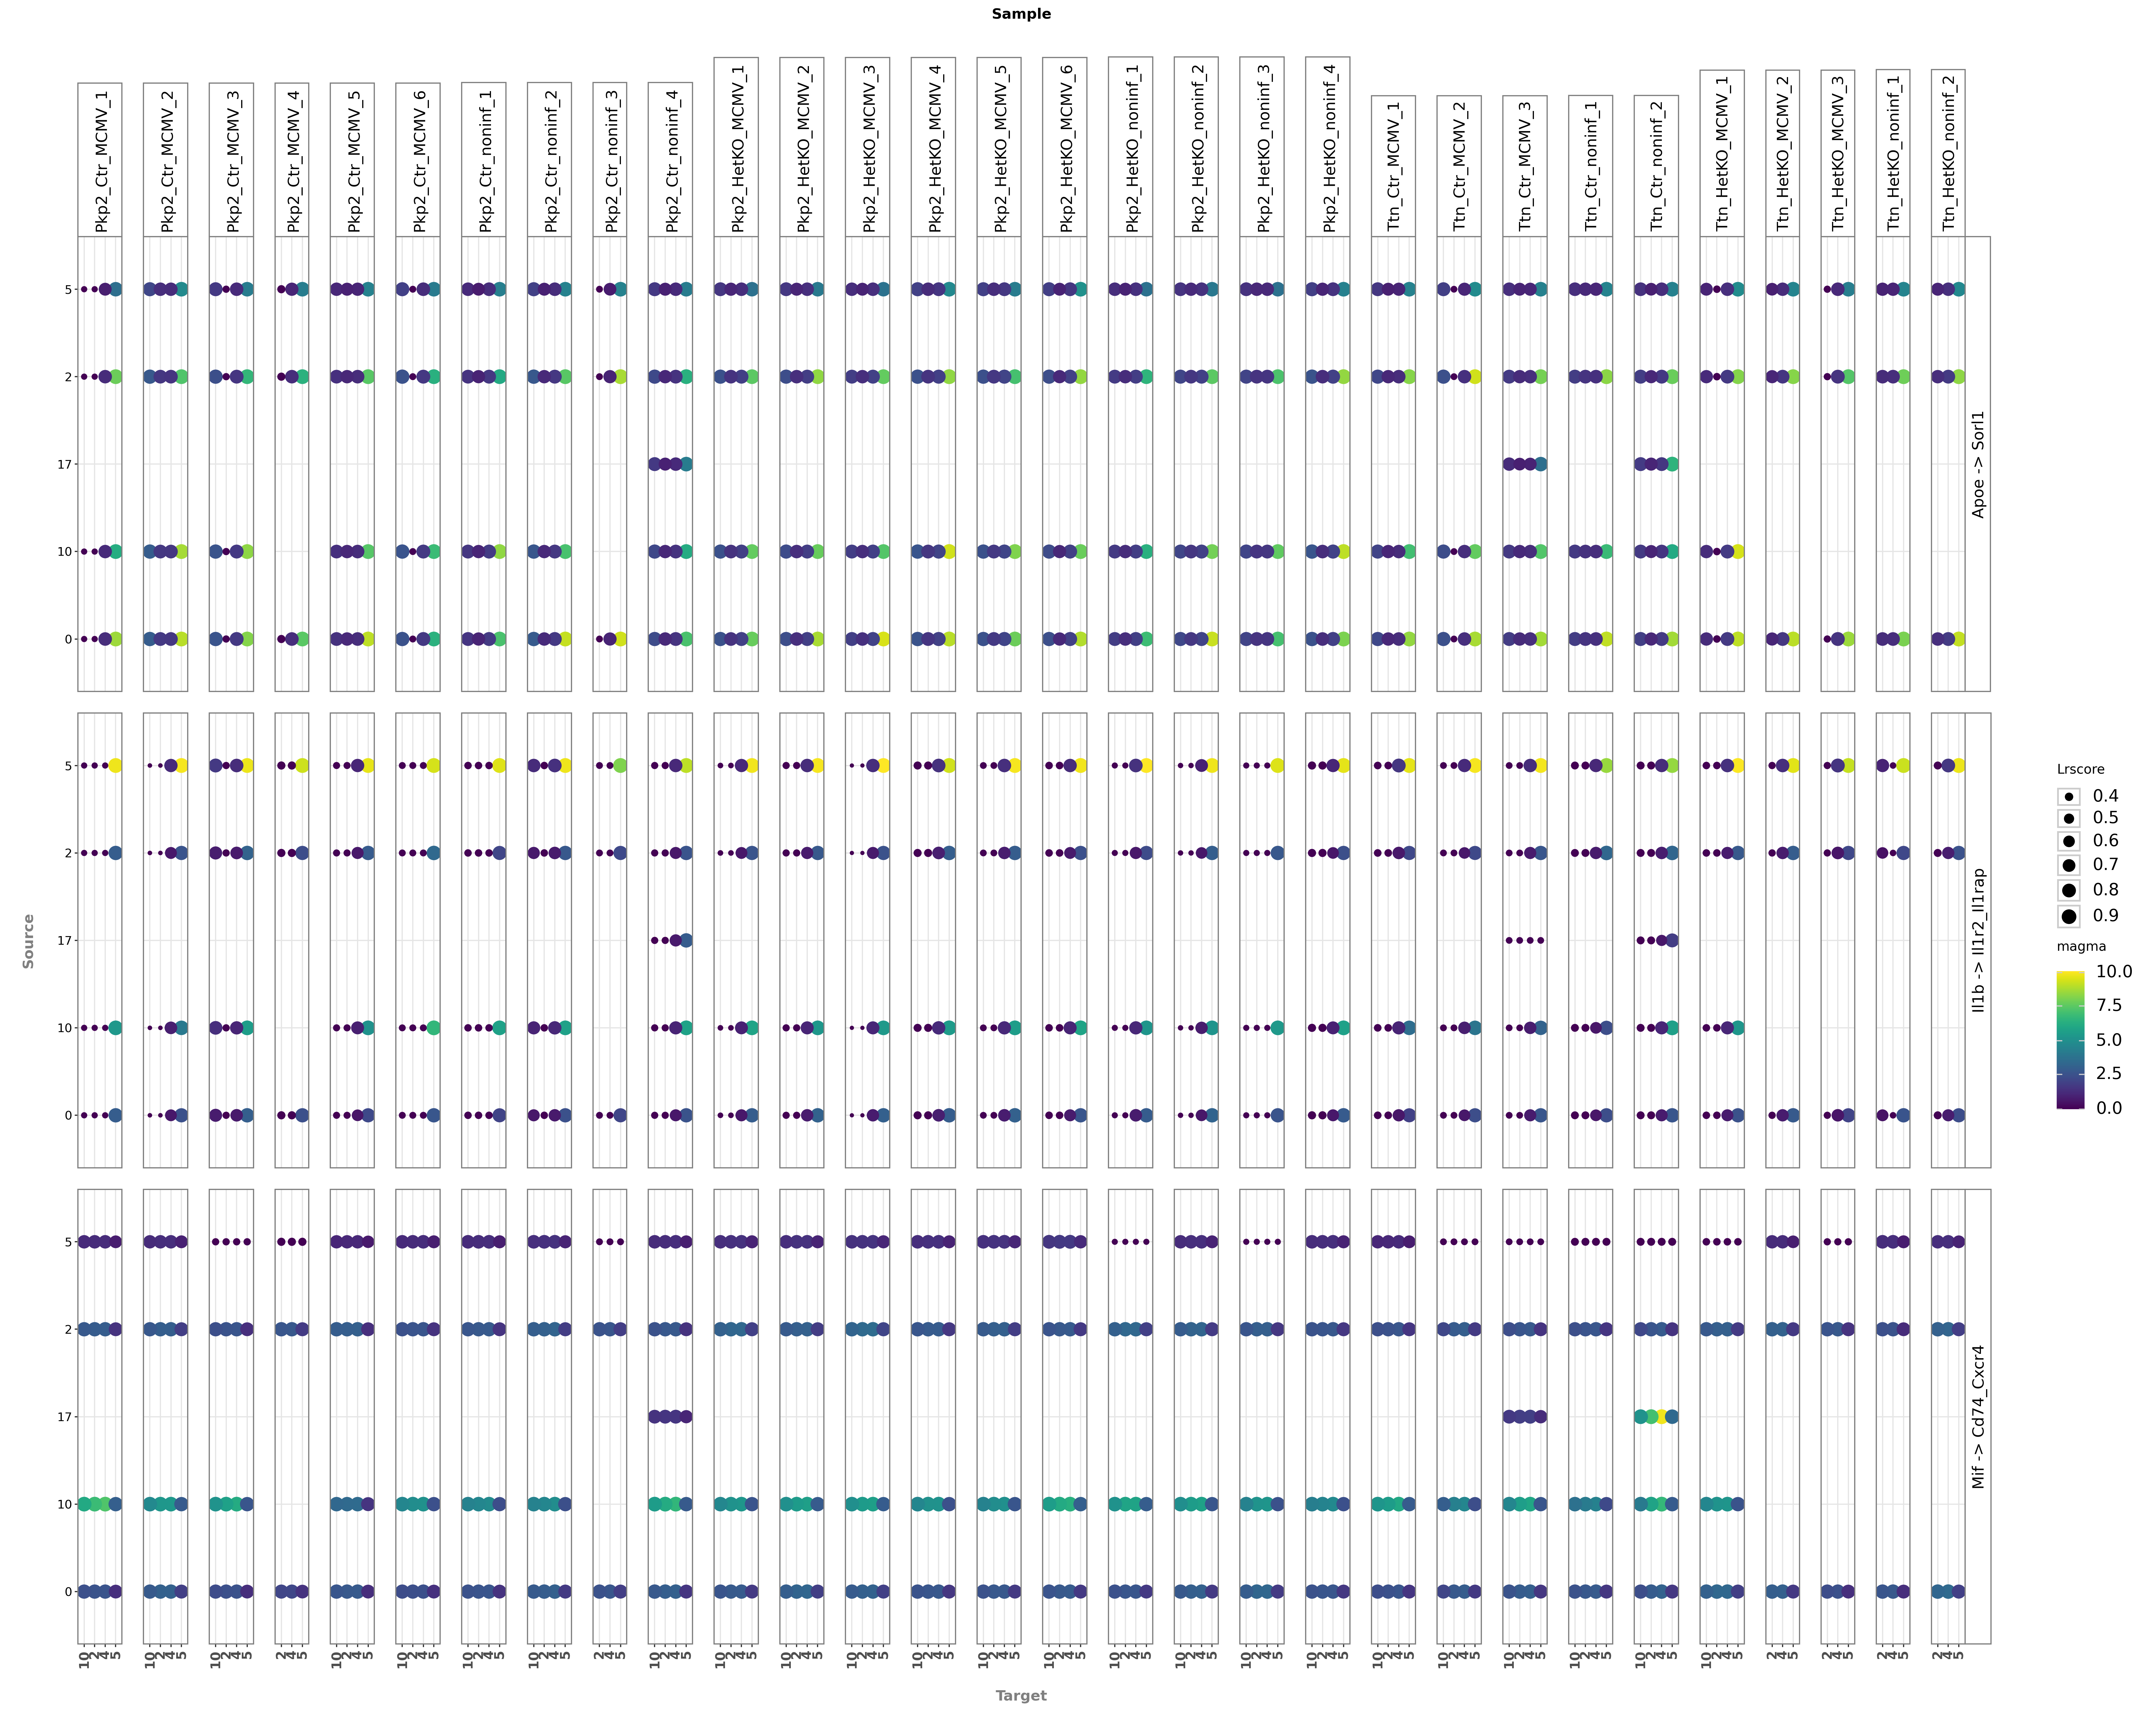

In [16]:
plot = li.pl.dotplot_by_sample(
    adata=adata,
    colour='magnitude_rank',
    size='lrscore',
    source_labels=["0","2", "5", "10", "17"],
    target_labels=["2", "4", "5",  "10"],
    ligand_complex=['Il1b', 'Mif', 'Apoe'],
    receptor_complex=['Il1r2_Il1rap', 'Cd74_Cxcr4', 'Cd74', 'Sorl1', 'Cd68'],
    sample_key='sample',
    inverse_colour=True,
    inverse_size=False,
    figure_size=(25, 20),
    size_range=(1, 6),
    cmap="magma"
)

plot.save(output_folder + '/Dotplot-by-sample.pdf', height=9, width=9)
plot


In [14]:
adata.uns['liana_res'].to_csv(output_folder + 'LIANA_by_sample_20240429.csv', index=False)

In [15]:
adata.write_h5ad(output_folder + 'adata_with_lr_interactions_20240429.h5ad')

### Building a Tensor

Before we can decompose the tensor, we need to build it. To do so, we will use the to_tensor_c2c function from liana. This function takes as input the pandas.DataFrame with the results from liana.by_sample, and returns a cell2cell.tensor.PrebuiltTensor object. This object contains the tensor, as well as other useful utility functions.

#### Reorder the samples, as this is later on needed for the tensor

In [17]:
#Generate a list containing all samples from the AnnData object
sorted_samples = sorted(adata.obs['sample'].unique())
sorted_samples = [  'Pkp2_Ctr_noninf_1', 'Pkp2_Ctr_noninf_2', 'Pkp2_Ctr_noninf_3', 'Pkp2_Ctr_noninf_4',
                    'Pkp2_HetKO_noninf_1', 'Pkp2_HetKO_noninf_2', 'Pkp2_HetKO_noninf_3', 'Pkp2_HetKO_noninf_4',
                    'Pkp2_Ctr_MCMV_1', 'Pkp2_Ctr_MCMV_2', 'Pkp2_Ctr_MCMV_3', 'Pkp2_Ctr_MCMV_4', 'Pkp2_Ctr_MCMV_5', 'Pkp2_Ctr_MCMV_6',
                    'Pkp2_HetKO_MCMV_1', 'Pkp2_HetKO_MCMV_2', 'Pkp2_HetKO_MCMV_3', 'Pkp2_HetKO_MCMV_4', 'Pkp2_HetKO_MCMV_5', 'Pkp2_HetKO_MCMV_6',
                    'Ttn_Ctr_noninf_1', 'Ttn_Ctr_noninf_2',
                    'Ttn_HetKO_noninf_1', 'Ttn_HetKO_noninf_2',
                    'Ttn_Ctr_MCMV_1', 'Ttn_Ctr_MCMV_2', 'Ttn_Ctr_MCMV_3',
                    'Ttn_HetKO_MCMV_1', 'Ttn_HetKO_MCMV_2', 'Ttn_HetKO_MCMV_3']

In [18]:
# Convert the 'sample' column to a categorical type with the order specified in sorted_samples
adata.obs['sample'] = pd.Categorical(adata.obs['sample'], categories=sorted_samples, ordered=True)

# Sort the DataFrame by the 'sample' column
adata.obs = adata.obs.sort_values('sample')

In [19]:
adata.obs.head(15)

,cell_source,donor,n_counts,sample,seed_labels,condition,genotype,infection,library,model,...,percent_chrY,XIST-counts,S_score,G2M_score,_scvi_batch,_scvi_labels,batch,C_scANVI,leiden,classification
AAACGCTGTTGTGTTG-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,478.0,Pkp2_Ctr_noninf_1,DOCK4+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,0.000000,0.0,-0.019995,-0.083225,6,1,reference,DOCK4+MØ,3,3
GGGACCTCACACGGTC-1-A2,AG_Gerull,Pkp2_Ctr_noninf_1,1772.0,Pkp2_Ctr_noninf_1,Monocytes,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A2,Pkp2,...,0.098961,0.0,0.034874,-0.359427,6,4,reference,Monocytes,3,3
GGCTTGGTCGGCGATC-1-A2,AG_Gerull,Pkp2_Ctr_noninf_1,3988.0,Pkp2_Ctr_noninf_1,Neutrophils,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A2,Pkp2,...,0.049128,0.0,-0.208259,-0.149788,6,6,reference,Neutrophils,5,5
GGCAGTCTCTGATGGT-1-A2,AG_Gerull,Pkp2_Ctr_noninf_1,2229.0,Pkp2_Ctr_noninf_1,DOCK4+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A2,Pkp2,...,0.124378,0.0,-0.207494,-0.381211,6,1,reference,DOCK4+MØ,3,3
GGCACGTTCGAAGCAG-1-A2,AG_Gerull,Pkp2_Ctr_noninf_1,5855.0,Pkp2_Ctr_noninf_1,Monocytes,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A2,Pkp2,...,0.016650,0.0,-0.535381,-0.208974,6,4,reference,Monocytes,6,6
GTTACCCGTCACTACA-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,7030.0,Pkp2_Ctr_noninf_1,Mast,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,0.013858,0.0,-0.706877,0.106556,6,3,reference,Mast,13,13
GGAGGTACAGCATCTA-1-A2,AG_Gerull,Pkp2_Ctr_noninf_1,12865.0,Pkp2_Ctr_noninf_1,MØ_general,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A2,Pkp2,...,0.014577,0.0,-0.083994,-0.266909,6,5,reference,MØ_general,4,4
GTTCCGTCACCCTTAC-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,771.0,Pkp2_Ctr_noninf_1,DOCK4+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,0.000000,0.0,-0.172588,-0.233279,6,1,reference,DOCK4+MØ,3,3
GCTTGGGTCCGTACGG-1-A2,AG_Gerull,Pkp2_Ctr_noninf_1,7025.0,Pkp2_Ctr_noninf_1,LYVE1+MØ,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A2,Pkp2,...,0.000000,0.0,-0.158382,-0.700571,6,2,reference,LYVE1+MØ,1,1
GCTGCAGTCGATAACC-1-A2,AG_Gerull,Pkp2_Ctr_noninf_1,11617.0,Pkp2_Ctr_noninf_1,Monocytes,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A2,Pkp2,...,0.016647,0.0,-0.767460,-0.805399,6,4,reference,Monocytes,6,6


Pass the communication scores from LIANA to build the 3D tensors for each sample and then concatenate them to obtain the 4D tensor

In [20]:
tensor = li.multi.to_tensor_c2c(liana_res=adata.uns['liana_res'], # LIANA's dataframe containing results
                                sample_key='sample', # Column name of the samples
                                source_key='source', # Column name of the sender cells
                                target_key='target', # Column name of the receiver cells
                                ligand_key='ligand_complex', # Column name of the ligands
                                receptor_key='receptor_complex', # Column name of the receptors
                                score_key='magnitude_rank', # Column name of the communication scores to use
                                inverse_fun=lambda x: 1 - x, # Transformation function
                                how='outer', # What to include across all samples                   #'outer_cells' would consider only LR pairs that are present in all conditions, however as we also have Ttn samples I rather take all LR pairs as they may differ between Ttn and Pkp2
                                outer_fraction=1/3., # Fraction of samples as threshold to include cells and LR pairs.
                                context_order=sorted_samples, # Order to store the contexts in the tensor
                               )

100%|██████████| 30/30 [18:55<00:00, 37.87s/it]


In [21]:
tensor.tensor.shape

torch.Size([30, 2293, 15, 15])

#### Create metadata

In [22]:
context_dict = adata.obs.sort_values(by='sample') \
                        .set_index('sample')['condition'] \
                        .to_dict()

In [23]:
dimensions_dict = [context_dict, None, None, None]
meta_tensor = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=dimensions_dict,
                                                  fill_with_order_elements=True
                                                 )

##### Export the tensor and its metadata

In [24]:
c2c.io.export_variable_with_pickle(variable=tensor, filename=output_folder + 'Tensor_20240429.pkl')
c2c.io.export_variable_with_pickle(variable=meta_tensor, filename=output_folder + '/Tensor-Metadata_20240429.pkl')

/home/acirnu/data/ACM_cardiac_leuco/Cell2cell/n_latent150/Tensor_20240429.pkl  was correctly saved.
/home/acirnu/data/ACM_cardiac_leuco/Cell2cell/n_latent150//Tensor-Metadata_20240429.pkl  was correctly saved.


##### Load the saved tensor with metadata

In [25]:
tensor = c2c.io.read_data.load_tensor(output_folder + 'Tensor_20240429.pkl')
meta_tensor = c2c.io.load_variable_with_pickle(output_folder + '/Tensor-Metadata_20240429.pkl')

### Run Tensor-cell2cell Factorization

In [ ]:
%%time
tensor2 = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    meta_tensor,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank= None, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    device=device, # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    #elbow_metric='error', # Metric to use in the elbow analysis.
                                                    #smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    #upper_rank=30, # Max number of factors to try in the elbow analysis
                                                    #tf_init='random', # Initialization method of the tensor factorization
                                                    #tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    #cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    #sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    #group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=True, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    output_folder= output_folder
                                                    )

Export Tensor and its metadata

In [ ]:
meta_tensor2 = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor2,
                                                  metadata_dicts=dimensions_dict,
                                                  fill_with_order_elements=True
                                                 )

In [ ]:
c2c.io.export_variable_with_pickle(variable=tensor2, filename=output_folder + 'Tensor_Factorized_20240429.pkl')
c2c.io.export_variable_with_pickle(variable=meta_tensor2, filename=output_folder + '/Tensor_Factorized-Metadata_20240429.pkl')

Load Tensor and its metadata

In [ ]:
tensor2 = c2c.io.read_data.load_tensor(output_folder + 'Tensor_Factorized_20240429.pkl')
meta_tensor2 = c2c.io.load_variable_with_pickle(output_folder + '/Tensor_Factorized-Metadata_20240429.pkl')

In [ ]:
tensor2.factors.keys()

In [ ]:
tensor2.factors['Contexts'].head(10)

##### Compare pairs within conditions with **boxplots** and statistical tests

In [ ]:
groups_order = ['Pkp2_Ctr_noninf', 'Pkp2_HetKO_noninf', 'Pkp2_Ctr_MCMV', 'Pkp2_HetKO_MCMV','Ttn_Ctr_noninf', 'Ttn_HetKO_noninf', 'Ttn_Ctr_MCMV', 'Ttn_HetKO_MCMV' ]
fig_filename = output_folder + '/Conditions_Boxplots_20240429.pdf'

_ = c2c.plotting.context_boxplot(context_loadings=tensor2.factors['Contexts'],
                                 metadict=context_dict,
                                 nrows=3,
                                 figsize=(5, 10),
                                 group_order=groups_order,
                                 statistical_test='Kruskal', #'t-test_ind', 't-test_welch', 't-test_paired', 'Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls', 'Levene', 'Wilcoxon', 'Kruskal'
                                 pval_correction='bonferroni', #'bonferroni', 'bonf', 'Bonferroni', 'holm-bonferroni', 'HB', 'Holm-Bonferroni', 'holm', 'benjamini-hochberg', 'BH', 'fdr_bh', 'Benjamini-Hochberg', 'fdr_by', 'Benjamini-Yekutieli', 'BY', None
                                 cmap='tab20',
                                 verbose=True
                                )

##### Heatmaps for the LR pairs with loadings above a certain threshold

In [ ]:
fig_filename = output_folder + '/Clustermap_LRs_20240429.pdf'

_ = c2c.plotting.loading_clustermap(loadings=tensor2.factors['Ligand-Receptor Pairs'],
                                    loading_threshold=0.1,
                                    use_zscore=False,
                                    figsize=(10, 3),
                                    filename=fig_filename,
                                    row_cluster=False,
                                    tick_fontsize=12,
                                    dendrogram_ratio=0.15,
                                   )

### Overall CCI potential

Define a threshold to indicate what pair of cells are interacting. To do so, we need to get all the outer products between the loadings for the sender and receiver cells dimensions across all factors.

In [ ]:
# Get all outer products as adjacency matrices, one per factor
networks = c2c.analysis.tensor_downstream.get_factor_specific_ccc_networks(tensor2.factors,
                                                                           sender_label='Sender Cells',
                                                                           receiver_label='Receiver Cells',
                                                                           )

In [ ]:
# Then, flatten the adjacency matrices
network_by_factors = c2c.analysis.tensor_downstream.flatten_factor_ccc_networks(networks, orderby='receivers')

# And we can plot the distributions of the weights for each factor-specific network
_ = plt.hist(network_by_factors.values.flatten(), bins = 50)

Chosen threshold = 0.042

In [ ]:
threshold = 0.042

##### Heatmap of sender-receiver cell pairs

Evaluate the overall interactions between sender-receiver cell pairs that are predominant in a given facort/interaction program.

X-axis = receiver cells, Y-axis = sender cells

In [ ]:
selected_factor = 'Factor 3'

In [ ]:
loading_product = c2c.analysis.tensor_downstream.get_joint_loadings(tensor2.factors,
                                                                    dim1='Sender Cells',
                                                                    dim2='Receiver Cells',
                                                                    factor=selected_factor,
                                                                   )

In [ ]:
lprod_cm = c2c.plotting.loading_clustermap(loading_product.T, # Remove .T to transpose the axes
                                           use_zscore=False, # Whether standardizing the loadings across factors
                                           figsize=(8, 8),
                                           filename=output_folder + '/Clustermap-CC-Pairs_20240429.pdf',
                                           cbar_label='Loading Product',
                                          )

##### Interaction network of sender-receiver cell pairs

In [ ]:
c2c.plotting.ccc_networks_plot(tensor2.factors,
                               included_factors= None,
                               ccc_threshold=threshold, # Only important communication
                               nrows=1,
                               panel_size=(12,12), # This changes the size of each figure panel.
                               node_label_size=30,
                               filename=output_folder + '/Factor-Networks_20240429.pdf',
                              )

### Pathway Enrichment Analysis: Interpreting the context-driven communication

##### Classical Pathway Enrichment with `KEGG Pathways`

In [ ]:
lr_loadings = tensor2.factors['Ligand-Receptor Pairs']

lr_pairs = li.resource.select_resource('mouseconsensus')

# Generate list with ligand-receptors pairs in DB
lr_list = ['^'.join(row) for idx, row in lr_pairs.iterrows()]

# Specify the organism and pathway database to use for building the LR set
organism = "mouse"
pathwaydb = "KEGG"

# Generate ligand-receptor gene sets
lr_set = c2c.external.generate_lr_geneset(lr_list,
                                          complex_sep='_',
                                          lr_sep='^',
                                          organism=organism,
                                          pathwaydb=pathwaydb,
                                          readable_name=True,
                                          output_folder=output_folder
                                         )

In [ ]:
pvals, scores, gsea_df = c2c.external.run_gsea(loadings=lr_loadings,
                                               lr_set=lr_set,
                                               output_folder=output_folder,
                                               weight=1,
                                               min_size=15,
                                               permutations=999,
                                               processes=6,
                                               random_state=6,
                                               significance_threshold=0.05,
                                              )

The enriched pathways are:

In [ ]:
gsea_df.loc[(gsea_df['Adj. P-value'] <= 0.05) & (gsea_df['NES'] > 0.)]

The depleted pathways are:

gsea_df.loc[(gsea_df['Adj. P-value'] <= 0.05) & (gsea_df['NES'] < 0.)]

In [ ]:
pathway_label = '{} Annotations'.format(pathwaydb)
fig_filename = output_folder + '/GSEA-Dotplot_20240429.pdf'

with sns.axes_style("darkgrid"):
    dotplot = c2c.plotting.pval_plot.generate_dot_plot(pval_df=pvals,
                                                      score_df=scores,
                                                      significance=0.05,
                                                      xlabel='',
                                                      ylabel='{} Annotations'.format(pathwaydb),
                                                      cbar_title='NES',
                                                      cmap='PuOr',
                                                      figsize=(8,12),
                                                      label_size=24,
                                                      title_size=24,
                                                      tick_size=20,
                                                      filename=fig_filename
                                                      )

#### Footprint enrichment

Footprint enrichment analysis build upon classic geneset enrichment analysis, as instead of considering the genes involved in a biological activity, they consider the genes affected by the activity, or in other words the genes that change downstream of said activity

In [ ]:
# We first load the PROGENy gene sets
net = dc.get_progeny(organism='human', top=5000)

# Then convert them to sets with weighed ligand-receptor pairs
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")

In [ ]:
estimate, pvals =  dc.run_mlm(lr_loadings.transpose(),
                              lr_progeny,
                              source="source",
                              target="interaction",
                              use_raw=False)

In [ ]:

fig_filename = output_folder + '/PROGENy_20240429.pdf'
_ = sns.clustermap(estimate, xticklabels=estimate.columns, cmap='coolwarm', z_score=4)

t = _.ax_heatmap.set_xticklabels(_.ax_heatmap.get_xmajorticklabels(), fontsize = 16)
t = _.ax_heatmap.set_yticklabels(_.ax_heatmap.get_ymajorticklabels(), fontsize = 16, rotation=0)

plt.savefig(fig_filename, dpi=300, bbox_inches='tight')

In [ ]:
selected_factor = 'Factor 5'
fig_filename = output_folder + '/PROGENy-{}_20240429.pdf'.format(selected_factor.replace(' ', '-'))

dc.plot_barplot(estimate,
                selected_factor,
                vertical=True,
                cmap='coolwarm',
                save=fig_filename)